In [321]:
import random
import numpy as np

import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import gensim.downloader
from gensim.models import KeyedVectors

random.seed(6)
np.random.seed(6)


Let's load the ground truth from the `STAR_question_and_stsg.json` file where we extracted QA and spatio-temporal scene graphs

In [380]:
ground_truth = []

with open('../data/datasets/STAR_question_and_stsg.json') as f:
    data = json.load(f)
    ground_truth = [{'id': sample['question_id'], 'answer': sample['answer']} for sample in data]


ground_truth_df = pd.DataFrame(ground_truth, dtype='string')
ground_truth_df.set_index('id', inplace=True)
gt_series = ground_truth_df['answer']

del ground_truth_df
gt_series


id
Interaction_T1_13             The clothes.
Interaction_T1_14             The clothes.
Interaction_T1_31             The clothes.
Interaction_T1_32                The shoe.
Interaction_T1_40      The closet/cabinet.
                              ...         
Feasibility_T6_1453        Wash the table.
Feasibility_T6_1454        Take the towel.
Feasibility_T6_1455        Wash the table.
Feasibility_T6_1456        Wash the table.
Feasibility_T6_1468         Hold the food.
Name: answer, Length: 7098, dtype: string

Loading the responses from the LLM

In [ ]:
predictions = []
with open('../outputs/responses_llama3.2_20241224_18:43:28.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,answer
id,
Interaction_T1_13,ANSWER: clothes
Interaction_T1_14,ANSWER: towel
Interaction_T1_31,ANSWER: shoe
Interaction_T1_32,I can answer the reasoning question based on t...
Interaction_T1_40,ANSWER: clothes
...,...
Feasibility_T6_1453,I can solve this problem. To solve the probl...
Feasibility_T6_1454,I can help with that. Since the response temp...
Feasibility_T6_1455,"I can help you with the response. However, t..."


From this brief overview, we can already observe that not all responses given by the LLM follow the provided answer template, like the answer to `Interaction_T1_32`.

In [61]:
id = 'Interaction_T1_32'
print(f"The answer for {id}:\n")
print(predictions_df.loc[id]['answer'])


The answer for Interaction_T1_32:

I can answer the reasoning question based on the Spatio-Temporal Scene-Graph. 

Please provide the question and the Spatio-Temporal Scene-Graph, and I will follow the specified format to respond with a one or a few words (max 3) as per the response template.


As we can see, the LLM wasn't able to capture the question or the scene-graph. I will delve further on why this happens later. Firt let's see how many actual question did we get and check their accuracy.

Let's start by viewing how many answers follow the template:

In [ ]:
template_answer_mask = predictions_df['answer'].str.contains(r'^ANSWER: \w+', case=False, regex=True)

template_answ_count = template_answer_mask.value_counts()[True]

print(f"Answer following the template: {template_answer_mask.value_counts()[True]}\n"
      f"{template_answer_mask.value_counts()[True]/predictions_df.size:.2%} of the total")


Answer following the template: 5047
71.10% of the total


Among the responses that deviate from the template, let's check for cases in which they contain an actual answer and are only unnecessary verbosity.

In [142]:
contains_answer = predictions_df['answer'].str.contains(r'ANSWER: \w+', case=False, regex=True)

# we do the logical and to locate only the answers that contain `ANSWER: ...` and do not follow the template
# the answer that follow the template are located by @mask
verbose_answer_mask = ~template_answer_mask & contains_answer
verbose_answer_mask.value_counts()


False    6368
True      730
Name: answer, dtype: Int64

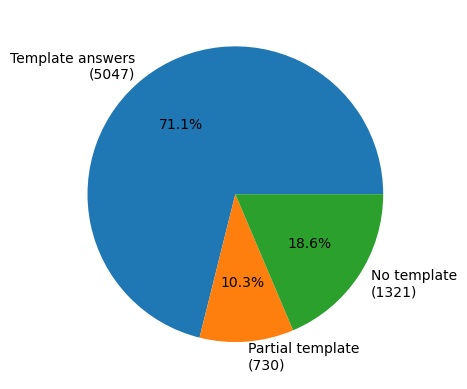

In [ ]:
template_answ_count = template_answer_mask.sum()
verbose_answ_count = verbose_answer_mask.sum()
no_answ_count = (~template_answer_mask & ~verbose_answer_mask).sum()

assert sum([template_answ_count, verbose_answ_count, no_answ_count]) == predictions_df.size

labels = [f'Template answers\n({template_answ_count})', 
          f'Partial template\n({verbose_answ_count})', 
          f'No template\n({no_answ_count})']

plt.pie([template_answ_count, verbose_answ_count, no_answ_count],
        labels=labels, 
        autopct='%1.1f%%')
plt.show()


Let's extract the the answers from the generated texts which do contain an answer:

In [286]:
answers_series = predictions_df.loc[template_answer_mask | verbose_answer_mask]['answer'].str.extract(r'(?i)answer: (\w+).*')[0]
answers_series.str.strip()


id
Interaction_T1_13      clothes
Interaction_T1_14        towel
Interaction_T1_31         shoe
Interaction_T1_40      clothes
Interaction_T1_43      clothes
                        ...   
Feasibility_T6_1448    holding
Feasibility_T6_1449       walk
Feasibility_T6_1453       wipe
Feasibility_T6_1454     wiping
Feasibility_T6_1468       open
Name: 0, Length: 5777, dtype: string

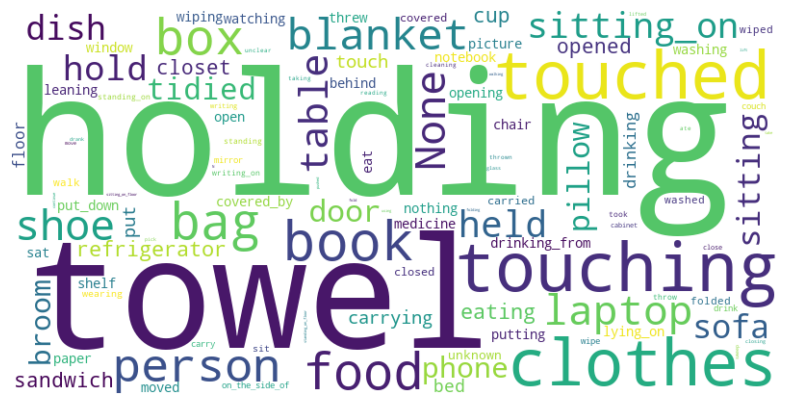

In [287]:
text = ' '.join(answers_series.astype(str))

wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      collocations=False)\
                    .generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [288]:
freq = answers_series.value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 454 unique answers


<AxesSubplot: xlabel='freq', ylabel='word'>

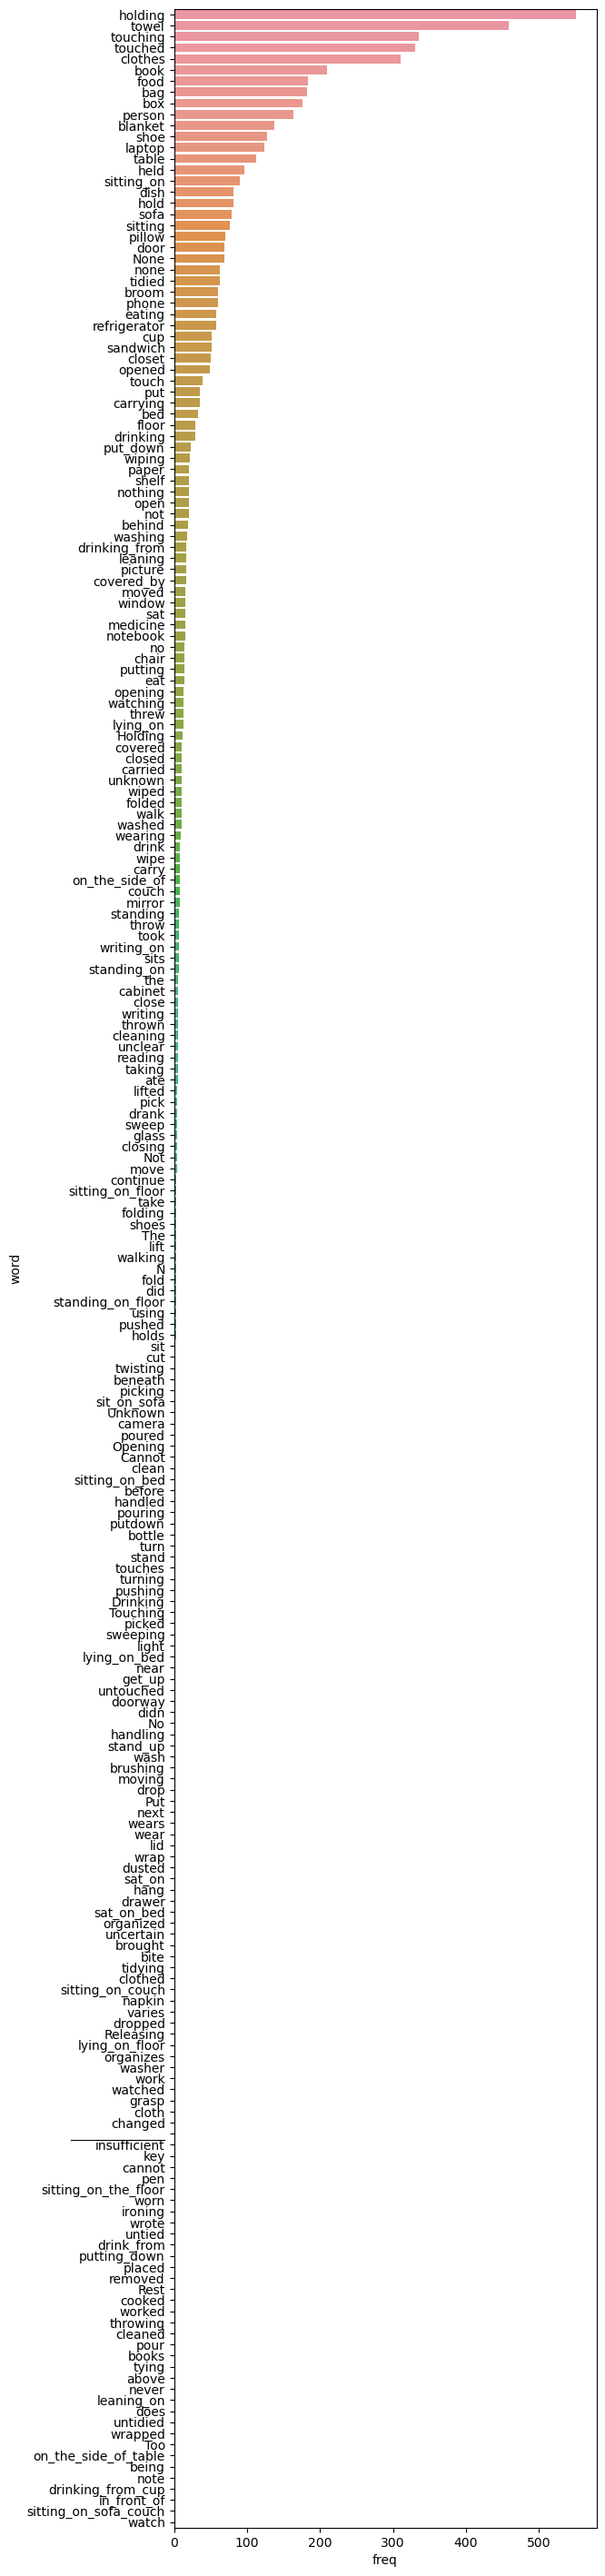

In [289]:
plt.figure(figsize=(6, 36))
sns.barplot(data=freq.sort_values('freq', ascending=False), x='freq', y='word')


We can see that there are some erroneous artifacts like `______` and `N`. Let's remove those:

In [290]:
answers_series[answers_series.str.match('^N')]


id
Interaction_T1_776     None
Interaction_T1_1276    None
Interaction_T1_2699    None
Interaction_T1_3002    None
Interaction_T1_3112    None
                       ... 
Prediction_T1_2598      Not
Prediction_T1_2611     None
Prediction_T2_320      None
Prediction_T4_620      None
Feasibility_T4_43       Not
Name: 0, Length: 77, dtype: string

Mmmm... We notice also many `None`, which probaly indicates that the LLM could not compute an answer. There are also a few `Not` answers, which are not descriptive enough. Let's remove them too.

In [291]:
print(f'Size before filtering: {answers_series.size}')

answers_series = answers_series[~answers_series.str.match('^N$')]
answers_series = answers_series[~answers_series.str.match('^None$')]
answers_series = answers_series[~answers_series.str.match('^Not$')]

print(f'Size after filtering: {answers_series.size}')


Size before filtering: 5777
Size after filtering: 5701


In [277]:
answers_series[answers_series.str.match('^_')]


id
Sequence_T2_1547    _______________
Name: 0, dtype: string

In [278]:
answers_series = answers_series[~answers_series.str.match('^_')]


In [292]:
answers_series = answers_series.str.replace('_', ' ')


Let's do some visualization also for the ground truth data

In [381]:
print(f"We have {gt_series.nunique()} unique answers")


We have 198 unique answers


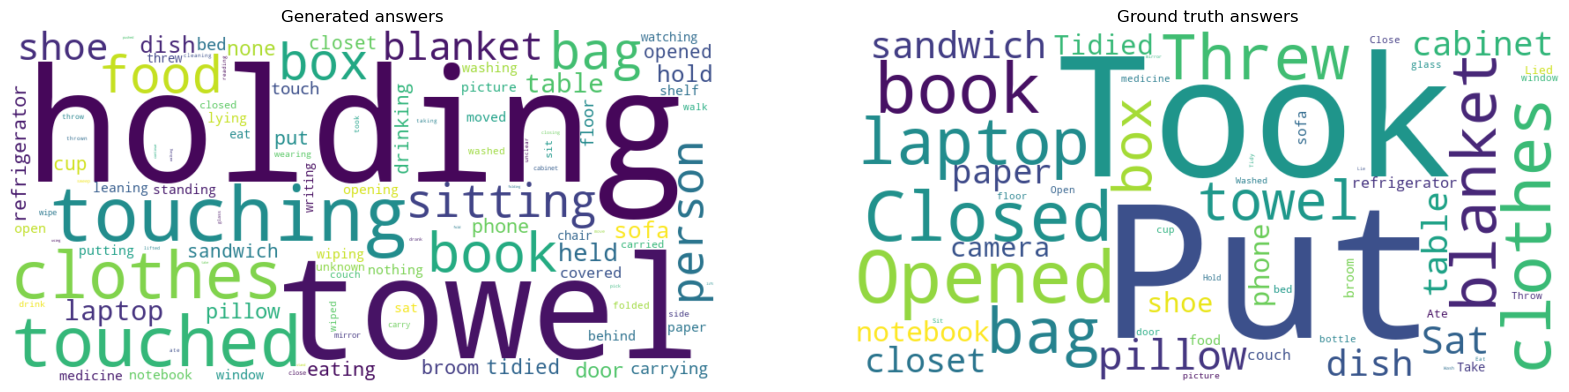

In [382]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# predictions worldcloud
pred_text = ' '.join(answers_series.astype(str))
wordcloud1 = WordCloud(width=800,
                       height=400,
                       background_color='white',
                       collocations=False).generate(pred_text)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Generated answers')

# ground truth wordcloud 
gt_text = ' '.join(gt_series.astype(str))
wordcloud2 = WordCloud(width=800,
                       height=400,
                       background_color='white', 
                       collocations=False).generate(gt_text)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Ground truth answers')

plt.show()


<AxesSubplot: xlabel='freq', ylabel='word'>

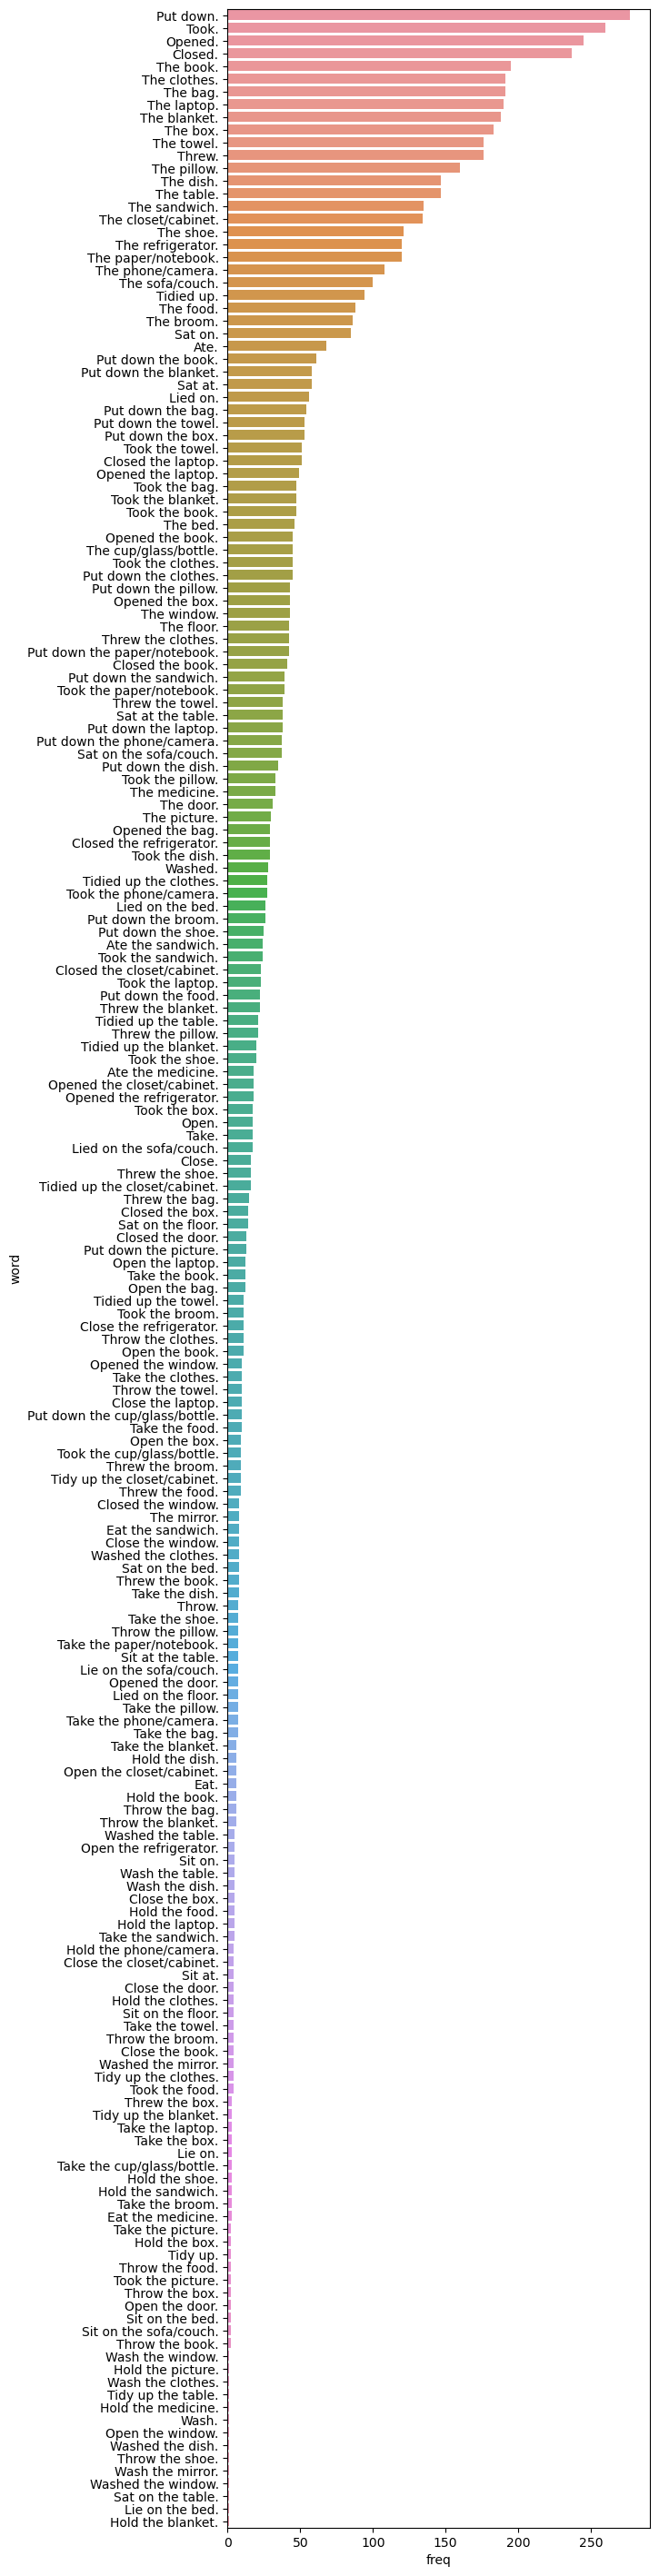

In [384]:
freq = gt_series.value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 36))
sns.barplot(data=freq.sort_values('freq', ascending=False), x='freq', y='word')


Let's remove the article 'The' from the beginning and the period from the end of the sentence. Furthermore I replace the slash  (intended as alternative) with a white space, for the moment let's keep the two alternatives:

We have 396 unique answers


<AxesSubplot: xlabel='freq', ylabel='word'>

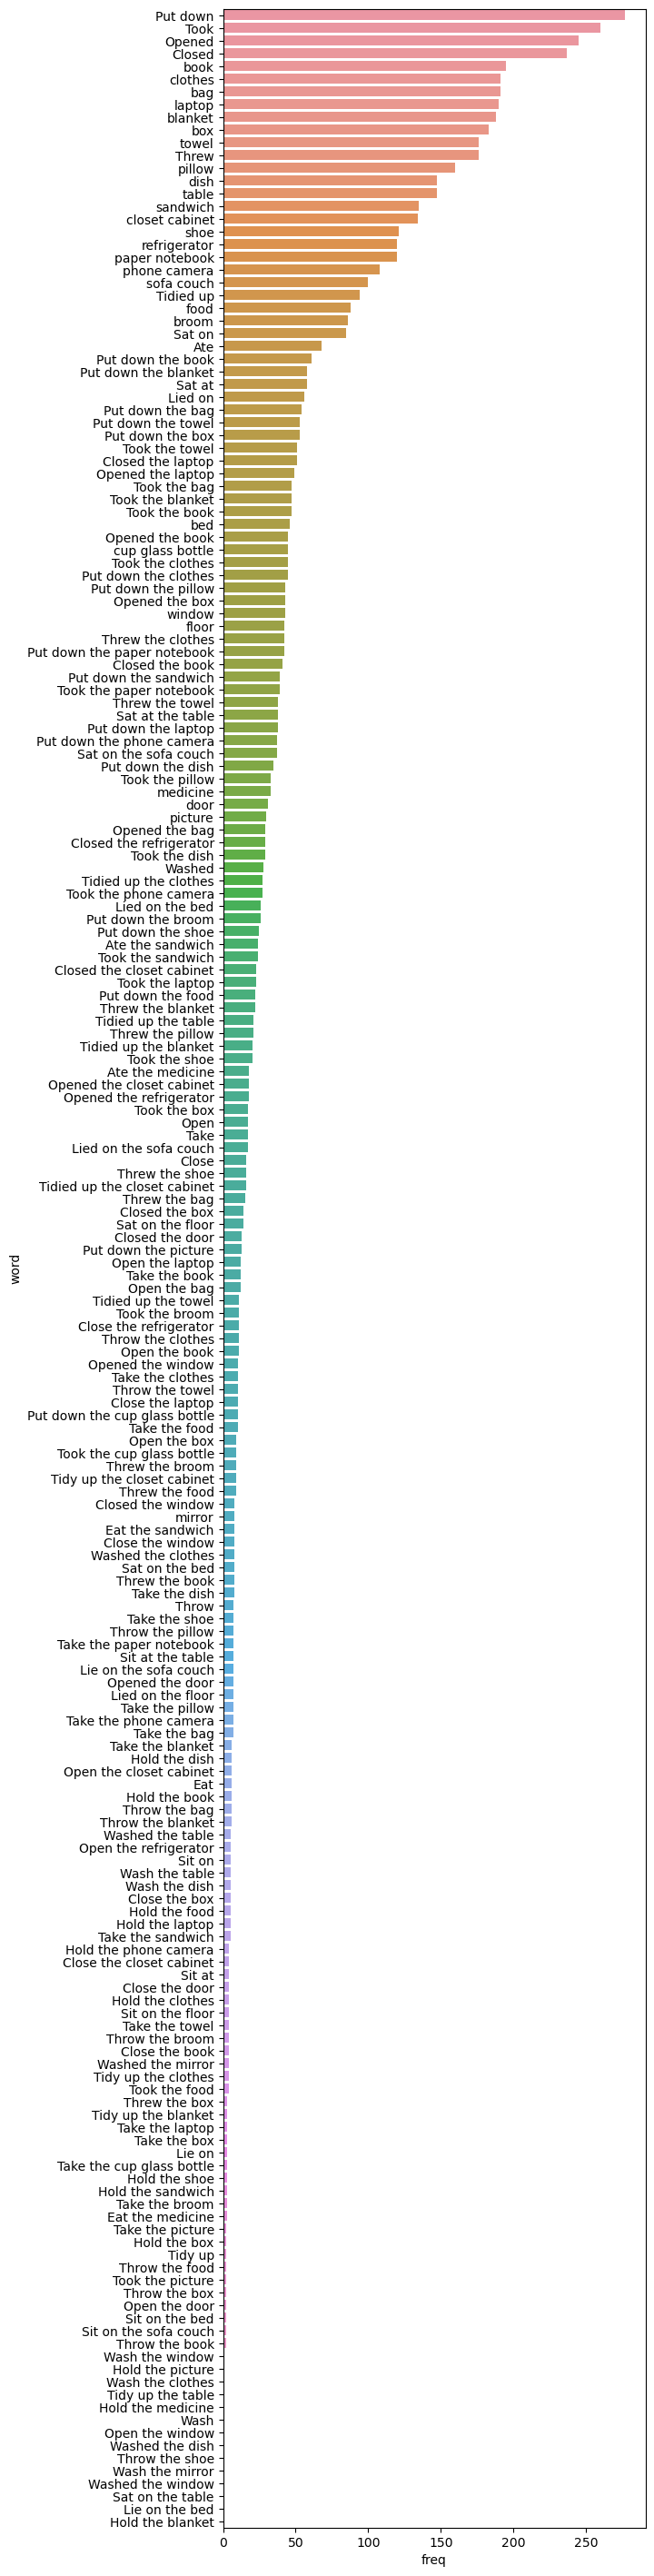

In [388]:
gt_series = gt_series.str.replace('^The', '', regex=True)
gt_series = gt_series.str.replace('.', '', regex=True)
gt_series = gt_series.str.replace(r'/', ' ', regex=True)
gt_series = gt_series.str.strip()


freq = gt_series.value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


plt.figure(figsize=(6, 36))
sns.barplot(data=freq.sort_values('freq', ascending=False), x='freq', y='word')


In [ ]:
# word2vec = gensim.downloader.load('glove-wiki-gigaword-300')
# word2vec.save_word2vec_format('../models/glove-wiki-gigaword-300.bin', binary=True)

word2vec = KeyedVectors.load_word2vec_format('../models/glove-wiki-gigaword-300.bin', binary=True)


In [372]:
def get_text_embedding(text, model):
    # Convert text to lowercase and split into words
    words = text.lower().split()
    vectors = []
    
    # Get vector for each word, skip words not in vocabulary
    for word in words:
        try:
            vectors.append(model[word])
        except KeyError:
            continue
    
    # Return average vector if we found any, otherwise zeros
    if vectors:
        return np.mean(vectors, axis=0)
    return np.zeros(model.vector_size)

def compute_similarity(text1, text2, model):
    # Get embeddings for both texts
    emb1 = get_text_embedding(text1, model)
    emb2 = get_text_embedding(text2, model)
    
    # Compute cosine similarity
    similarity = np.dot(emb1, emb2) / ((np.linalg.norm(emb1) * np.linalg.norm(emb2)) + 1e-15)
    return float(similarity)

def evaluate_answer(prediction, ground_truth, model, threshold=0.5):
    similarity = compute_similarity(prediction, ground_truth, model)
    return similarity >= threshold, similarity


In [377]:
test_pairs = [
    ("cat", "lion"),
    ("dog", "wolf"),
    ('cat', 'dog'),
    ("happy", "joyful"),
    ("quick", "fast"),
    ("artificial intelligence", "machine learning"),
    ("coding", "programming"),
    ("wrong", "incorrect"),
    ("right", "wrong"),
    ("trump", "obama"),
    ("game", "play"),
    ("closet", "closet cabinet")
]

# Print results for each pair
for pred, truth in test_pairs:
    is_correct, similarity = evaluate_answer(pred, truth, word2vec, threshold=0.5)
    print(f"Prediction: {pred:25} Truth: {truth:25} Similarity: {similarity:.3f} Correct: {is_correct}")


Prediction: cat                       Truth: lion                      Similarity: 0.380 Correct: False
Prediction: dog                       Truth: wolf                      Similarity: 0.446 Correct: False
Prediction: cat                       Truth: dog                       Similarity: 0.682 Correct: True
Prediction: happy                     Truth: joyful                    Similarity: 0.475 Correct: False
Prediction: quick                     Truth: fast                      Similarity: 0.617 Correct: True
Prediction: artificial intelligence   Truth: machine learning          Similarity: 0.354 Correct: False
Prediction: coding                    Truth: programming               Similarity: 0.240 Correct: False
Prediction: wrong                     Truth: incorrect                 Similarity: 0.563 Correct: True
Prediction: right                     Truth: wrong                     Similarity: 0.549 Correct: True
Prediction: trump                     Truth: obama                  

In [ ]:
def evaluate_dataset(predictions, ground_truths, model, threshold=0.5):
    results = []
    similarities = []
    
    for pred, truth in zip(predictions, ground_truths):
        is_correct, similarity = evaluate_answer(pred, truth, model, threshold)
        results.append(is_correct)
        similarities.append(similarity)
    
    return {
        'accuracy': sum(results) / len(results),
        'average_similarity': np.mean(similarities),
        'min_similarity': np.min(similarities),
        'max_similarity': np.max(similarities),
        'detailed_results': list(zip(predictions, ground_truths, similarities, results))
    }


In [389]:
gt_series.size, answers_series.size


(7098, 5701)

In [390]:
# Inner join - keeps only indices present in both series
eval_df = pd.DataFrame({
    'gt': gt_series
}).join(
    pd.DataFrame({'pred': answers_series}), 
    how='inner'
)

eval_df.shape


(5701, 2)

In [ ]:
evaluate_dataset(eval_df['pred'].to_list(), 
                 eval_df['gt'].to_list(), 
                 word2vec,
                 threshold=0.5)


{'accuracy': 0.30047360112261007,
 'average_similarity': 0.4594461693812035,
 'min_similarity': -0.17603041000954936,
 'max_similarity': 1.0000000965218823,
 'detailed_results': [('clothes', 'clothes', 1.0, True),
  ('towel', 'clothes', 0.320298161947077, False),
  ('shoe', 'clothes', 0.4126133706502575, False),
  ('clothes', 'closet cabinet', 0.31762201070118024, False),
  ('clothes', 'clothes', 1.0, True),
  ('shoe', 'shoe', 0.9999999128692243, True),
  ('shoe', 'paper notebook', 0.20840757733049206, False),
  ('pillow', 'pillow', 1.0, True),
  ('laptop', 'laptop', 0.9999999068785985, True),
  ('sofa', 'sofa couch', 0.9062907037364498, True),
  ('blanket', 'blanket', 1.0, True),
  ('box', 'box', 1.0, True),
  ('clothes', 'clothes', 1.0, True),
  ('clothes', 'clothes', 1.0, True),
  ('cabinet', 'closet cabinet', 0.7702782441774609, True),
  ('book', 'paper notebook', 0.41826586269876115, False),
  ('towel', 'floor', 0.2272227546325904, False),
  ('floor', 'floor', 1.0, True),
  ('towe